<a href="https://colab.research.google.com/github/Migaalee/machine_learning/blob/main/Assignment1_AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Project description
## Dataset 
The data set is inspired on the banknote authentication problem in the UCI machine learning repository, but the data was adapted for this assignment. The data are available on .tsv files where each line corresponds to a bank note and the five values, separated by commas, are, in order, the four features (variance, skewness and curtosis of Wavelet Transformed image and the entropy of the bank note image) and the class label, an integer with values 0 for real bank notes and 1 for fake bank notes.

## Objective
Parametrize, fit and compare Naive Bayes and Support Vector Machine classifiers using described dataset.

# Import all packages that will be used

In [22]:
# Numpy for data management
import numpy as np

# Pandas also for data management
import pandas as pd

# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

import math

#ScikitLearn

from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold

from sklearn.neighbors import KernelDensity

from sklearn.model_selection import StratifiedKFold

from sklearn.utils import shuffle

from sklearn.naive_bayes import GaussianNB

from google.colab import files #this is to load files from your local disk

from sklearn.svm import SVC

#from sklearn.svm import SVC #penso q faltava este??

#import McNemar



# Upload data

Import training dataset

In [ ]:
TP1_train = files.upload() 
 

Saving TP1_train.tsv to TP1_train.tsv


Import testing dataset

In [ ]:
TP1_test = files.upload()

Saving TP1_test.tsv to TP1_test.tsv


# Store all functions that might be useful

In [17]:
# Function to exapnd data to get different models

def poly_16features(X):
    """Expand data polynomially
    """
    X_exp = np.zeros((X.shape[0],X.shape[1]+14))
    X_exp[:,:2] = X 
    X_exp[:,2] = X[:,0]*X[:,1]
    X_exp[:,3] = X[:,0]**2
    X_exp[:,4] = X[:,1]**2
    X_exp[:,5] = X[:,0]**3
    X_exp[:,6] = X[:,1]**3
    X_exp[:,7] = X[:,0]**2*X[:,1]
    X_exp[:,8] = X[:,1]**2*X[:,0]
    X_exp[:,9] = X[:,0]**4
    X_exp[:,10] = X[:,1]**4
    X_exp[:,11] = X[:,0]**3*X[:,1]
    X_exp[:,12] = X[:,1]**3*X[:,0]
    X_exp[:,13] = X[:,0]**2*X[:,1]**2
    X_exp[:,14] = X[:,0]**5
    X_exp[:,15] = X[:,1]**5        
    return X_exp

def poly_mat(reg,X_data,feats,ax_lims):
    """create score matrix for contour
    """
    Z = np.zeros((200,200))
    xs = np.linspace(ax_lims[0],ax_lims[1],200)
    ys = np.linspace(ax_lims[2],ax_lims[3],200)
    X,Y = np.meshgrid(xs,ys)
    points = np.zeros((200,2))
    points[:,0] = xs
    for ix in range(len(ys)):
        points[:,1] = ys[ix]
        x_points=poly_16features(points)[:,:feats]
        Z[ix,:] = reg.decision_function(x_points)
    return (X,Y,Z)

def create_plot(X_r, Y_r, X_t, Y_t, feats, best_c):
    """create imege with plot for best classifier"""
    ax_lims=(-3,3,-3,3)
    plt.figure(figsize=(8,8), frameon=False)
    plt.axis(ax_lims)
    reg = LogisticRegression(C=best_c, tol=1e-10)
    reg.fit(X_r,Y_r)
    plotX,plotY,Z = poly_mat(reg,X_r,16,ax_lims)
    plt.contourf(plotX,plotY,Z,[-1e16,0,1e16], colors = ('b', 'r'),alpha=0.5)
    plt.contour(plotX,plotY,Z,[0], colors = ('k'))
    plt.plot(X_r[Y_r>0,0],X_r[Y_r>0,1],'or')
    plt.plot(X_r[Y_r<=0,0],X_r[Y_r<=0,1],'ob')
    plt.plot(X_t[Y_t>0,0],X_t[Y_t>0,1],'xr',mew=2)
    plt.plot(X_t[Y_t<=0,0],X_t[Y_t<=0,1],'xb',mew=2)
    plt.savefig('final_plot.png', dpi=300)
    plt.close()
    

# Calculate training and validation errors for each fold using Brier score
def calc_fold(feats, X,Y, train_ix,test_ix,C=1e12):  #number of features, matrix with features, label classes, indexes to use for points in training and validation, large C regularization parameter (=almost no regularization)
  """return classification error for train and test sets"""
  reg = LogisticRegression(C=C, tol=1e-10) # make logistic regression object
  reg.fit(X[train_ix,:feats],Y[train_ix]) # fit with data that was chosen by kfold for training, :feats will fit 6 features if we say 6 in a function
  prob = reg.predict_proba(X[:,:feats])[:,1] #Brier score, which is specific for logistic. Computes prob that point belongs to class 1 [:,1] using all features X[:,:feats]
  squares = (prob-Y)**2 #Brier
  return (np.mean(squares[train_ix]),np.mean(squares[test_ix]))

#instead of calculating Brier score we could use "test_error = 1-reg.score(X_t,Y_t)". This would compare different classifiers

    


# Data preparation

Read data, shuffle, standardize

In [18]:
#NAO FAZ MAIS SENTIDO FAZER ISTO PRIMEIRO??

# Read data
mat_train = np.loadtxt("TP1_train.tsv", delimiter="\t")
mat_test = np.loadtxt("TP1_test.tsv", delimiter="\t")
print(mat_test)

# Shuffle data
data_train = shuffle(mat_train)
data_test = shuffle(mat_test)


# Standardize training dataset
Y_r = data_train[:,4] #classes
X_r = data_train[:,:4] #features
means_r = np.mean(X_r, axis = 0)
stdvs_r = np.std(X_r,axis = 0)
X_r = (X_r-means_r)/stdvs_r

# Standardize testing dataset
Y_t = data_test[:,4]
X_t = data_test[:,:4]
means_t = np.mean(X_t, axis = 0)
stdvs_t = np.std(X_t,axis = 0)
X_t = (X_t-means_t)/stdvs_t


[[-2.5290e+00 -3.7678e+01  8.9150e+00 -1.0600e+00  1.0000e+00]
 [-1.4550e+00  1.2616e+01  3.0000e-03 -2.7890e+00  0.0000e+00]
 [ 1.4390e+00  5.1210e+00  1.1852e+01  1.6770e+00  0.0000e+00]
 ...
 [ 1.2150e+00  6.5280e+00  1.3714e+01  1.6350e+00  0.0000e+00]
 [-6.0000e-03 -4.7880e+00 -3.8340e+00 -1.2540e+00  0.0000e+00]
 [-1.6070e+00  4.3610e+00  5.5270e+00 -1.9970e+00  0.0000e+00]]


# Bayes classifiers

## Naive Bayes

## Gaussian Bayes

In [19]:
NB_gaussian = GaussianNB() #criar o modelo do Naive Bayes usando Gaussiana
NB_gaussian.fit(X_r, Y_r) #usar os nossos dados de treino para fazer fit ao modelo
NB_gaussian_score = NB_gaussian.score(X_r, Y_r) #TODO confirmar q isto está bem!!! #aqui temos o score de avaliacao deste modelo

NB_gaussian_probs = NB_gaussian.predict_proba(X_t) #aqui podemos ver as probabilidades de ser classe 0 ou classe 1, sendo que a classe prevista é a q aumenta esta probabilidade
NB_gaussian_predict = NB_gaussian.predict(X_t) #aqui temos as previsoes do nosso modelo para o X de teste, podemos comparar estes resultados com o Y_t 

# SVM classifier

Notes: use a Support Vector Machine with a Gaussian radial basis function, available in the sklearn.svm.SVC class. Use a regularization factor C = 1 and optimize the gamma parameter with cross-validation on the training set. The SVM classifier you will use has two adjustable parameters, gamma and C. In this assignment we fixed parameter C at a value of 1 but you can try to improve the performance of this classifier by adjusting simultaneously these two parameters. This is an optional exercise, worth only 1/20 of the assignment grade: optimize both parameters, compare the optimized SVM with the previous classifiers and discuss whether this additional optimization was useful in this case. Use 5 folds for cross validation

##### Make a function to caculate best gammma

In [57]:
from sklearn.svm import SVC

gamma_range = np.arange(0.2,6.2,0.2) # To optimize the gamma parameter of the SVM try values from 0.2 to 6 with a step of 0.2
#c_range = np.arrange(0.1, 10.0, 0.1)

train_err=[]
valid_err=[]
folds = 10
kf = StratifiedKFold(n_splits=folds)

for gamma in gamma_range:
  tr_err = va_err = 0

  for tr_ix,va_ix in kf.split(Y_r,Y_r):

    x_t = X_r[tr_ix]
    y_t = Y_r[tr_ix]
    x_v = X_r[va_ix]
    y_v = Y_r[va_ix]

    svm = SVC(C=1, gamma = gamma) 
    svm.fit(x_t,y_t) #re-fit all training data with training dataset


    svm_t_error = 1-svm.score(x_t,y_t) #calculate error with training set for that fold
    tr_err += svm_t_error


    svm_v_error = 1-svm.score(x_v,y_v) #calculate validation error for that fold with a validation dataset
    va_err += svm_v_error


    #r,v = calc_fold(feats,X_r,Y_r,tr_ix,va_ix)
    #tr_err += r
    #va_err += v

  train_err.append(tr_err/folds)
  valid_err.append(va_err/folds)
  print(str(np.round(gamma,2)),':', tr_err/folds,va_err/folds)


0.2 : 0.0340641552217351 0.03527741935483871
0.4 : 0.03094305599946574 0.03126451612903226
0.6 : 0.029962186804816805 0.032070967741935484
0.8 : 0.02924901531450306 0.03287741935483871
1.0 : 0.027733148242672312 0.03287741935483871
1.2 : 0.02648466084998592 0.03287741935483871
1.4 : 0.025860138881600804 0.032870967741935486
1.6 : 0.024789984114641717 0.035270967741935486
1.8 : 0.02398760655831548 0.035270967741935486
2.0 : 0.023184910976798468 0.035270967741935486
2.2 : 0.022204280301042646 0.034464516129032265
2.4 : 0.021758329477277894 0.03365806451612904
2.6 : 0.021490790785538116 0.03365806451612904
2.8 : 0.021312378653513132 0.03365806451612904
3.0 : 0.02122325209379834 0.03365806451612904
3.2 : 0.020688254216616485 0.032858064516129035
3.4 : 0.02050984208459152 0.03365806451612904
3.6 : 0.019885479128801807 0.03365806451612904
3.8 : 0.019617940437062033 0.032858064516129035
4.0 : 0.019439528305037045 0.03365806451612904
4.2 : 0.019439528305037045 0.03525806451612904
4.4 : 0.01935


##### Best gamma for SVC is:

In [71]:
print("smallest validation error is: "+ str(np.min(valid_err)))

#which corresponds to gamma: 
print("best gamma is: ", gamma_range[np.argmin(valid_err)])


best_gamma = gamma_range[np.argmin(valid_err)]

smallest validation error is: 0.03126451612903226
best gamma is:  0.4


##### Now plot training and validation errors for different gamma

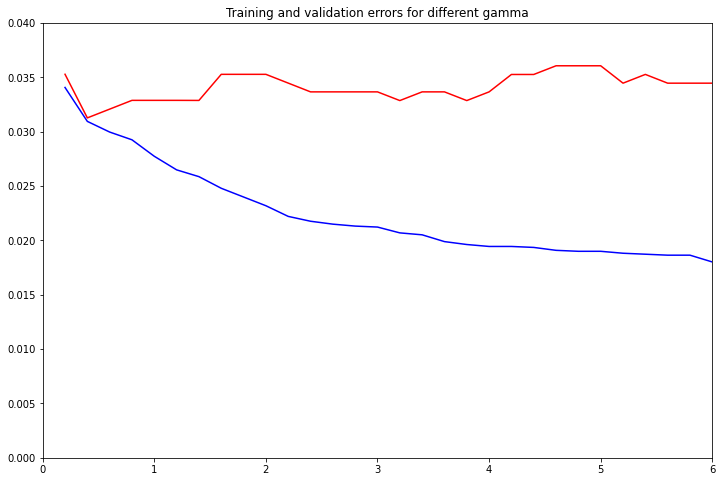

In [58]:
gamma_range = np.arange(0.2,6.2,0.2)
plt.figure(figsize=(12, 8))
plt.plot(gamma_range, train_err, c='b')
plt.plot(gamma_range, valid_err, c='r')
plt.axis([0, 6,0.0,0.04])
plt.title('Training and validation errors for different gamma')
plt.show()
plt.close()


##### Calculate test error based on the model with best gamma. Need to re-check here true error calculation!

In [72]:
svm = SVC(C=1, gamma = best_gamma) #change gamma number here after
svm.fit(X_r,Y_r) #re-fit all training data with training dataset 
#svm_prob = svm.fit.predict_proba(X_t) # do not forget to calculate error with test!!! dataset
svm_true_error= 1 - svm.score(X_t, Y_t)
print ('SVM true error is: ', np.round(svm_true_error,6))


SVM true error is:  0.073777


# Comparison of classifiers

Here we can do accuracy, precision, recall, F1 metric and ROC 

Calculate 